# Training a Generative-Adversarial Network

In our previous chapters, we've focused on classification networks: taking an input and outputting a fixed label.  In this chapter, we'll examine generative networks: instead of simply classifying an image as containing a cat, these networks allow us to create new images of cats!  Cute lovers rejoice!

Most GAN research focuses on real life images from the CIFAR or ImageNet datasets.  For this section we'll show how to train on CIFAR as well as a very different dataset of icons.

## Loading CIFAR

In [15]:
from keras.datasets import cifar10
import numpy as np
import nb_utils

(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar10.load_data()
cifar_x_train = cifar_x_train.astype('float32')
cifar_x_train /= 255
cifar_x_train -= 0.5

## Building our network

Now let's build our GAN network.  The basic idea with a GAN network is to construct 2 sub-networks that we will have "fight" against each other.

* Generator: this network starts with a random data seed, and it's goal is to generate an image that fools the discriminator
* Discriminator: this network is presented an image, and must decide whether it is a real image, or a fake generated by the generator network

By playing these networks against each other, we can cause the generator network to produce more and more convincing "fakes".

The generator and discriminator models below are based on an existing working GAN implementation.  GANs are very fickle: it's best to always start with something you know works and tweak it!

### Generator Network

Our generator network is effectively an upside down convolutional network.  Normal CNNs start with an image and producing a small dimensional label.  A generative network starts with a small random seed ("label"), and runs inverted CNN to produce successively larger images.

In [52]:
def adam():
    import keras.optimizers
    return keras.optimizers.Adam()
#     return keras.optimizers.Adam(lr=1e-4, beta_1=0.2)


In [6]:
import keras
from keras.models import Model
import keras.layers as L
import keras.backend as K
from keras.layers.merge import Concatenate

# Using https://github.com/ctmakro/hellotensor/blob/master/lets_gan_clean.py
# as a basis

noise_size = 100

img_width = 32
img_height = 32


def deconv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2DTranspose(
            num_filters, (kernel_size, kernel_size), 
            padding=padding,
            strides=strides)(layer)
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.Activation('relu')(layer)
        return layer

def build_cifar_generator(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    
    
    reshaped = deconv(reshaped, 192, 4, padding='valid', strides=1)
    reshaped = deconv(reshaped, 96, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 48, 4, padding='same', strides=2)
#     reshaped = deconv(reshaped, 24, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 3, 4, normalize=False, strides=2)    
    reshaped = L.Activation(activation='tanh')(reshaped)
    
    return Model(inputs=[input], outputs=[reshaped])

gen_net_cifar = build_cifar_generator(noise_size)
gen_net_cifar.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 4, 4, 192)         307392    
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 192)         768       
_________________________________________________________________
activation_5 (Activation)    (None, 4, 4, 192)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 96)          295008    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 96)          384       
__________

### Discriminator Network

Our discriminator network is just a standard CNN, and looks like the inverse of our generator.  We stack a number of CNN layers, terminating in dense layer with a single output to decide if we are looking at a real or fake image.

In [7]:
def batch_discrimination(i):
    """
    GAN networks often end up with a generator that outputs the same image for every
    sample, fooling the discriminator.  This isn't very interesting behavior, so we
    give the generator an extra hint: the variance of the data across it's inputs.
    
    A batch where all of the images are the same will therefore look very suspicious
    and be weeded out quickly.
    """
    batch_variance = L.Lambda(lambda x: K.mean(K.abs(x[:] - K.mean(x,axis=0)),axis=-1,keepdims=True))(i)
    return Concatenate()([i,batch_variance])

def build_cifar_discriminator():
    input = L.Input(shape=(img_width, img_height, 3))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            strides=strides)(layer)
        
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
            layer = batch_discrimination(layer)
        
        return layer
    
    l = conv(input, 32, kernel_size=4, strides=2)
    l = conv(l, 64, kernel_size=4, strides=2)
    l = conv(l, 128, kernel_size=4, strides=2)
    l = conv(l, 256, kernel_size=4, strides=2)
    l = L.Flatten()(l)
    
    discriminator = L.Dense(units=1,activation='sigmoid')(l)
    return Model(inputs=[input], outputs=[discriminator])

dis_net_cifar = build_cifar_discriminator()
dis_net_cifar.compile(loss='binary_crossentropy', metrics=['accuracy'], 
                optimizer=adam())
dis_net_cifar.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 16, 16, 32)    1568        input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_7 (BatchNorm (None, 16, 16, 32)    128         conv2d_1[0][0]                   
____________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)        (None, 16, 16, 32)    0           batch_normalization_7[0][0]      
___________________________________________________________________________________________

## Combined Model

Now let's build the combined model which runs both our generator and discrimnator: this will be used for training.

In [8]:
# Disable training of the discriminator network for this step.
# Depending on the Keras version, we also disable/enable during training.
#
# We use the combined GAN network to train the generator portion only.
def make_gan(gen_net, dis_net):
    dis_net.trainable = False

    latent = L.Input(shape=(noise_size, ))
    generated = gen_net([latent])
    g_score = dis_net(generated)

    GAN = Model(inputs=[latent], outputs=[g_score])
    GAN.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    GAN.summary()

    dis_net.trainable = True
    
    return GAN

## Training the GAN

Now we're finally ready to train the generator network.  We do this by alternating the following:

* Generate a batch of images G
* Train the discriminator to distinguish true images from G
* Generate a new batch G'
* Train the generator based on how well G' fooled the discriminator

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import IPython

class Stat(object):
    def __init__(self, name):
        self._v = [(0, 0)]
        self.name = name
        
    def __repr__(self):
        return '%s(%0.6f, %0.6f)' % (self.name, self.loss(), self.accuracy())
    
    def record(self, v):
        self._v.append(v)
        
    def loss(self, last=50):
        return np.mean(self._v[-last:], axis=0)[0]
    
    def accuracy(self, last=50):
        return np.mean(self._v[-last:], axis=0)[1]
    
def train(gen_net, dis_net, x_train, total_examples=1000*1000, batch_size = 128):    
    d_loss = Stat('Dis')
    g_loss = Stat('Gen')

    samples = []
    import time
    
    GAN = make_gan(gen_net, dis_net)
    start = time.time()

    np.random.shuffle(x_train)

    for i in range(total_examples // batch_size):
        if i % 100 == 0:
            gen_img = gen_net.predict(np.random.normal(loc=0.,scale=1.,size=(16, noise_size)))
            gen_img *= 0.5
            gen_img += 0.5
            samples.append(gen_img[0])

            IPython.display.clear_output(wait=True)
            print('\r', '%5d/%5d %4.2f %s %s' % (
                i, total_examples/batch_size, time.time() - start, d_loss, g_loss),
                  flush=True, end='')

            nb_utils.plot_images(gen_img)
            plt.show()

        # Train the discriminator network
        # Use separate batches for true and fake images    
        j = i % int(x_train.shape[0]/batch_size)
        image_batch = x_train[j:j+batch_size]
        gen_batch =  gen_net.predict(np.random.normal(loc=0.,scale=1.,size=(batch_size, noise_size)))

        dis_net.trainable = True
        d_loss.record(dis_net.train_on_batch(image_batch, np.ones(batch_size)))
        d_loss.record(dis_net.train_on_batch(gen_batch, np.zeros(batch_size)))
        dis_net.trainable = False


        # Now train the generator network -- it should generate inputs which
        # "fool" the discriminator and cause it to produce 1s.
        seed = np.random.normal(loc=0.,scale=1.,size=(2*batch_size, noise_size))
        g_loss.record(GAN.train_on_batch(seed, np.ones(2*batch_size)))
    
    return samples

   700/ 7812 93.84 Dis(0.007681, 1.000000) Gen(2.782012, 0.505391)

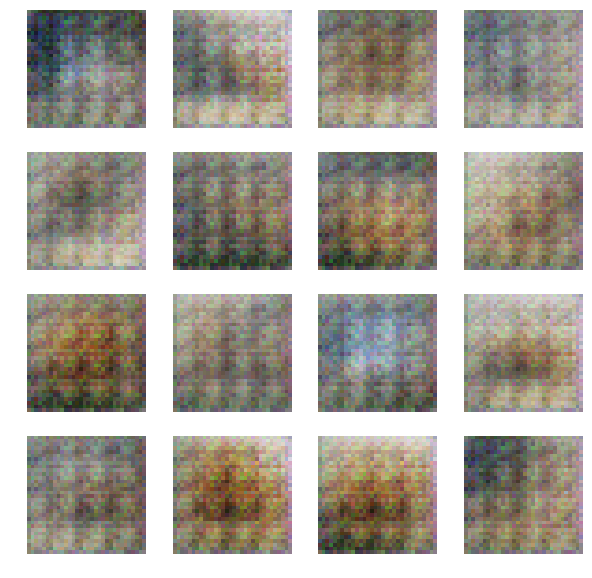

KeyboardInterrupt: 

In [17]:
samples = train(gen_net_cifar, dis_net_cifar, cifar_x_train)

## Visualizing the network progress

We saved our training samples every 100 batches; now we can observe how our network evolved over time.

In [18]:
samples = np.asarray(samples)
n = (samples - samples.min()) / (samples.max() - samples.min())
nb_utils.plot_images(n)

NameError: name 'samples' is not defined

## Data collection

To train our GAN, we'll need a set of real icons to compare against.  Unfortunately, no such download is trivially available, so you'll have to do a little bit of manual work to acquire the data.

Start here: https://icons8.com/app/ and download the app.  Open up the resulting DMG image, right click, and select "Show Package Contents".  Now copy out the resources/icons.tar.gz file to somewhere on your file system and extract the contents.  We'll assume it's at ~/.cache/dl-cookbook/icons/.

On Linux and Windows, you can use 7z to extract the DMG contents and access icons.tar.gz


## Loading the data

Our icon data is store as a LevelDB database.  Python wrappers exist for LevelDB, making it easy to read.  Each icon record is in a custom format which we don't have a parser for.  We'll do our best to pull out the information we want: namely, the category and icon SVG itself.  Fortunately, the format appears to be consistent across the vast majority of the icons -- we ignore any icons we can't parse.

In [22]:
import itertools, io
import sys
from cairosvg import svg2png
import scipy.ndimage
from PIL import Image
import urllib

import os

img_width = 32
img_height = 32

DB_LOCATION = os.path.expanduser('~/.cache/dl-cookbook/icons/')

def load_image(v):
    try:
        cat = v.replace(b'\x00', b'').split(b'\x08')[2].decode('utf8')
        
        start_idx = v.find(b'<?xml')
        end_idx = v.find(b'</svg>')
        v = v[start_idx:end_idx+6]    
        png = svg2png(bytestring=bytes(v))        
        
        with io.BytesIO(png) as f:
            img = Image.open(f)
            img.load()
            img = img.resize((img_width, img_height))
            background = Image.new('RGB', img.size, (255, 255, 255))
            background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
            img = background.convert('L')
            return np.asarray(img), cat
    except urllib.error.URLError:
        # Some SVG files try to read external URLs and fail.  Skip these.
        return None
    except:
        print(sys.exc_info())
        return None

import leveldb
ldb = leveldb.LevelDB(DB_LOCATION)
try:
    l_iter = ldb.RangeIter(None, None)

    import multiprocessing
    with multiprocessing.Pool() as pool:
        handles = []
        for k,v in l_iter:
            handles.append(pool.apply_async(load_image, (v,)))

        results = [h.get() for h in handles]
        results = [r for r in results if r is not None]
        images = [r[0] for r in results]
        categories = [r[1] for r in results]
finally:
    del ldb

(<class 'IndexError'>, IndexError('list index out of range',), <traceback object at 0x7fb2131a3c48>)


## Prepping our data

Before training our network, we want to normalize our data to make the models work a little easier: we'll normalize all of our images to have values between -1 and 1.  We'll also transform our categories we collected up above into labels from [0, num_labels].  We will use these labels to pre-train our discriminator network.

In [30]:
img_array = np.asarray(
    [2 * (img / (1e-9 + img.max()) - 0.5) for img in images]
)

# add a single dimension for our grayscale value, for compatibility with our models.
img_array = img_array[:,:,:,np.newaxis]

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

# Shuffle our data before processing it further.
shuffle_idx = np.arange(img_array.shape[0])
np.random.shuffle(shuffle_idx)
img_array = img_array[shuffle_idx]
category_labels = category_labels[shuffle_idx]

icon_x_train = img_array

In [24]:
# Let's take a quick look at what our categories are like.

import collections
import pandas as pd
counts = collections.Counter(categories)
pd.DataFrame({ 'category': list(counts.keys()), 'count': list(counts.values()) }).head()

,category,count
0,Messaging,1267
1,Finance,812
2,Editing,1437
3,Astrology,384
4,Time And Date,1272


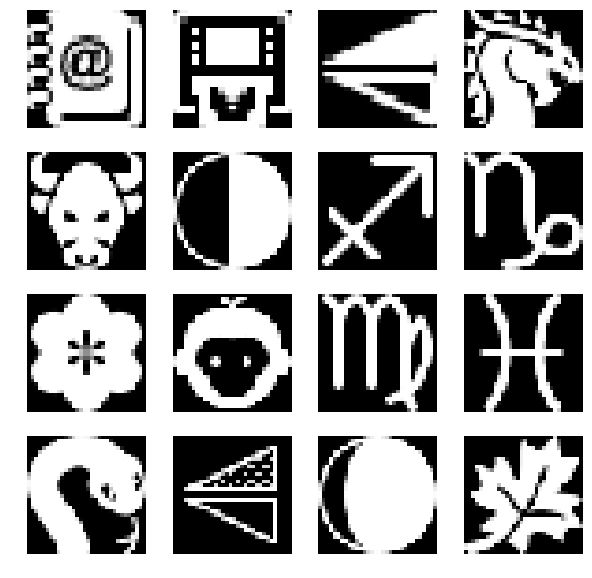

In [25]:
%matplotlib inline
nb_utils.plot_images(images[:16])

## Building our networks

As with CIFAR, we'll build discriminator and generator networks for our icons.

In [58]:
def build_icon_gen(seed_shape):
    input = L.Input(shape=(seed_shape,))
    reshaped = L.Reshape((1,1,seed_shape))(input)
    
    reshaped = deconv(reshaped, 64, 4, padding='valid', strides=2)
    reshaped = deconv(reshaped, 32, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 16, 4, padding='same', strides=2)
    reshaped = deconv(reshaped, 1, 4, normalize=False, strides=2)    
    reshaped = L.Activation(activation='tanh')(reshaped)
    
    return Model(inputs=[input], outputs=[reshaped])

gen_net_icon = build_icon_gen(noise_size)
gen_net_icon.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100)               0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose_65 (Conv2DT (None, 4, 4, 64)          102464    
_________________________________________________________________
batch_normalization_69 (Batc (None, 4, 4, 64)          256       
_________________________________________________________________
activation_65 (Activation)   (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_66 (Conv2DT (None, 8, 8, 32)          32800     
_________________________________________________________________
batch_normalization_70 (Batc (None, 8, 8, 32)          128       
__________

In [59]:
def build_icon_discriminator():
    input = L.Input(shape=(img_width, img_height, 1))
    def conv(layer, num_filters, kernel_size, strides, normalize=True, padding='same'):
        layer = L.Conv2D(
            num_filters, kernel_size, 
            padding=padding,
            kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            bias_initializer='zeros',
            strides=strides)(layer)
        
        if normalize:
            layer = L.BatchNormalization()(layer)
            layer = L.LeakyReLU(0.2)(layer)
            layer = batch_discrimination(layer)
        
        return layer
    
    l = conv(input, 16, kernel_size=4, strides=2)
    l = conv(l, 32, kernel_size=4, strides=2)
    l = conv(l, 64, kernel_size=4, strides=2)
    l = conv(l, 128, kernel_size=4, strides=2)
    l = L.Flatten()(l)
    
    discriminator = L.Dense(units=1,activation='sigmoid')(l)
    return Model(inputs=[input], outputs=[discriminator])

dis_net_icon = build_icon_discriminator()
dis_net_icon.compile(loss='binary_crossentropy', metrics=['accuracy'], 
                optimizer=adam())
dis_net_icon.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_37 (InputLayer)            (None, 32, 32, 1)     0                                            
____________________________________________________________________________________________________
conv2d_21 (Conv2D)               (None, 16, 16, 16)    272         input_37[0][0]                   
____________________________________________________________________________________________________
batch_normalization_72 (BatchNor (None, 16, 16, 16)    64          conv2d_21[0][0]                  
____________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)       (None, 16, 16, 16)    0           batch_normalization_72[0][0]     
___________________________________________________________________________________________

 39000/39062 4286.10 Dis(0.000000, 1.000000) Gen(16.118101, 0.000000)

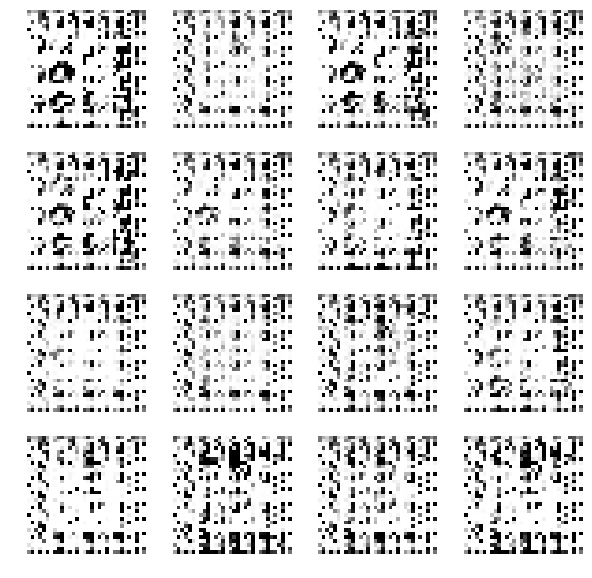

In [60]:
import importlib
importlib.reload(nb_utils)
samples = train(gen_net_icon, dis_net_icon, icon_x_train, total_examples=5*1000*1000)